<a href="https://colab.research.google.com/github/ProfAI/machine-learning-fondamenti/blob/main/Progetto%20Finale%20-%20Cross%20Selling%20di%20Polizze/health_insurance_cross_sell_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsione di opportunità di Cross Sell di assicurazioni

Il cliente è una compagnia di assicurazioni che ha fornito un'assicurazione sanitaria ai suoi clienti, adesso hanno bisogno del tuo aiuto per costruire un modello predittivo in grado di prevedere se gli assicurati dell'anno passato potrebbero essere interessati ad acquistare anche un'assicurazione per il proprio veicolo.

Il dataset è composto dalle seguenti proprietà:
- **id**: id univoco dell'acquirente.
- **Gender**: sesso dell'acquirente.
- **Age**: età dell'acquirente.
- **Driving_License**: 1 se l'utente ha la patente di guida, 0 altrimenti.
- **Region_Code**: codice univoco della regione dell'acquirente.
- **Previously_Insured**: 1 se l'utente ha già un veicolo assicurato, 0 altrimenti.
- **Vehicle_Age**: età del veicolo
- **Vehicle_Damage**: 1 se l'utente ha danneggiato il veicolo in passato, 0 altrimenti.
- **Annual_Premium**: la cifra che l'utente deve pagare come premio durante l'anno.
- **Policy_Sales_Channel**: codice anonimizzato del canale utilizzato per la proposta (es. per email, per telefono, di persona, ecc...)
- **Vintage**: numero di giorni dalla quale l'utente è cliente dell'azienda.
- **Response**: 1 se l'acquirente ha risposto positivametne alla proposta di vendità, 0 altrimenti.

L'obiettivo del modello è prevedere il valore di **Response**.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

data = pd.read_csv('./insurance_cross_sell.csv')

X = data.drop(["Response", "id"], axis=1)
y = data["Response"].astype(int)

# Split in train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

In [ ]:
numerical_variables = ['Age', 'Annual_Premium', 'Vintage']
categorical_variables = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Region_Code']

X_train[numerical_variables].describe()

,Age,Annual_Premium,Vintage
count,266776.000000,266776.000000,266776.000000
mean,38.851666,30580.218359,154.277158
std,15.514634,17260.739703,83.670493
min,20.000000,2630.000000,10.000000
25%,25.000000,24406.000000,82.000000
50%,36.000000,31680.000000,154.000000
75%,49.000000,39411.250000,227.000000
max,85.000000,540165.000000,299.000000


1. **Age**

A mean of 38.85 years, with a standard deviation of 15.51, indicates a reasonable spread in ages (the range spans from 20 to 85 years). With the 25th percentile at 25 and the 75th percentile at 49, the dataset is slightly right-skewed (the median is 36).
Since age is a continuous variable, it can be used as-is, but normalization or scaling might be necessary.

2. **Annual_Premium**

A mean of 30580.22 with a standard deviation of 17260,74, indicates a substantial variability in premium amounts.
The range spans from 2630 to 540165, with a high maximum value suggesting a potential for outliers.
Distribution: The 25th percentile is at 24406 and the 75th percentile at 39411, showing a large difference between the extremes, which hints at a right-skewed distribution (with many lower values and a few very high ones).
The high variability and possible outliers in Annual_Premium might require careful handling to prevent outliers from badly influencing the model. This feature is likely important as it directly relates to the customer's financial characteristics.

3. **Vintage**

Mean of 154,28 with a standard deviation of 83.67, representing the number of days the customer has been associated with the company.
Range shows values ranging from 10 to 299 days.
Vintage could reflect customer loyalty or engagement, so this could be a valuable feature. Similar to age, scaling or normalizing might be necessary.


In [ ]:
X_train[categorical_variables].describe()

,Driving_License,Previously_Insured,Region_Code
count,266776.000000,266776.00000,266776.000000
mean,0.997833,0.45831,26.414434
std,0.046497,0.49826,13.214658
min,0.000000,0.00000,0.000000
25%,1.000000,0.00000,15.000000
50%,1.000000,0.00000,28.000000
75%,1.000000,1.00000,35.000000
max,1.000000,1.00000,52.000000


1. **Driving_License**

The mean of 0.9978 and the low std of 0.046 indicates that nearly all individuals in the dataset have a driving license (99.78%).
Since this feature is binary (1 = has a license, 0 = no license), it can be used directly in the model without further transformation, though it won't carry much variance due to the overwhelmingly high proportion of drivers with a license.

2. **Previously_Insured**

The mean of 0.4583 indicates that about 45.83% of individuals have been previously insured. The standard deviation is relatively high (0.498), reflecting a more balanced split between those who have and haven't been insured before. As with Driving_License, this feature is binary and can be used directly without any additional transformation.

3. **Region_Code**

Since Region_Code is categorical (representing geographic regions), it may need to be encoded, for instance, using one-hot encoding or another suitable method to capture geographic diversity without implying an ordinal relationship.


In [ ]:
X_train.isnull().sum()

,0
Gender,0
Age,0
Driving_License,0
Region_Code,0
Previously_Insured,0
Vehicle_Age,0
Vehicle_Damage,0
Annual_Premium,0
Policy_Sales_Channel,0
Vintage,0


Since all columns have complete data, there is no need for missing value handling or imputation at this stage.

,Response
count,266776.000000
mean,0.122095
std,0.327396
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


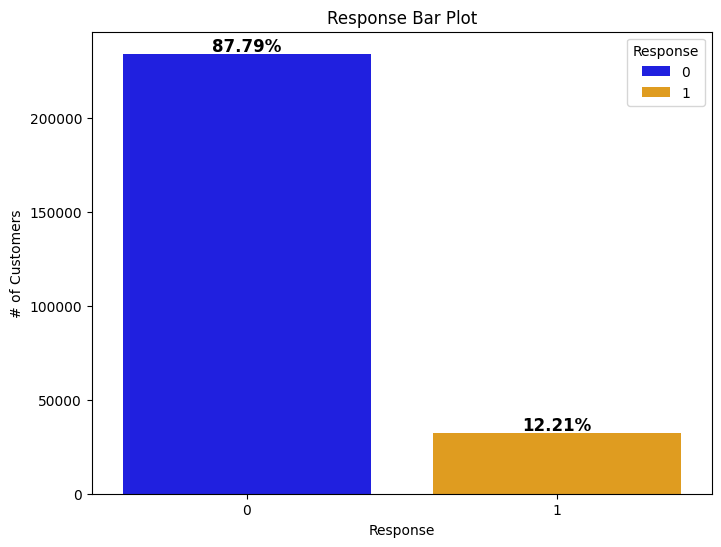

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
ax = sns.countplot(x ='Response', data = data_train, hue='Response', dodge=False, palette=['blue', 'orange'])
ax.set_title("Response Bar Plot")
ax.set_ylabel("# of Customers")
counts = data_train.Response.value_counts().values
for i, count in enumerate(counts):
    ax.text(i, count + 1000, f'{count/len(data_train.Response)*100:.2f}%', ha='center', fontsize=12, fontweight='bold')

data_train.Response.describe()

The dataset is **imbalanced**: there is a significant class imbalance with the majority of customers not responding positively. This can have implications for modeling, as models may be biased towards predicting the majority class (0).

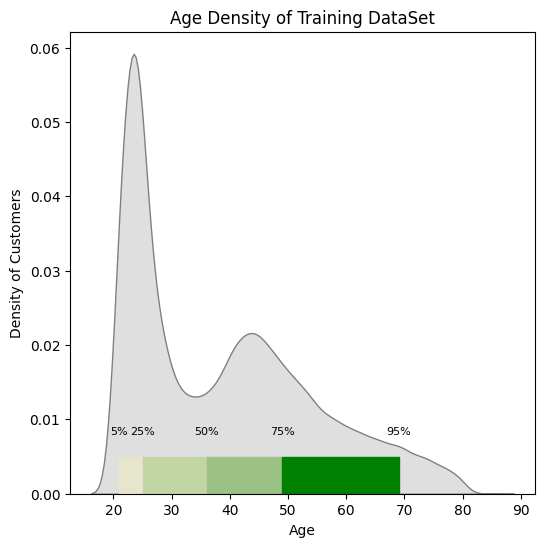

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(X_train['Age'], color='grey', ax=ax, fill=True)

quantiles_to_compute = [5, 25, 50, 75, 95]
quantiles = np.percentile(X_train['Age'], quantiles_to_compute)

colors = ['#E7E5CB', '#C2D6A4', '#9BC184', 'green']
for i in range(len(quantiles) - 1):
    ax.fill_between([quantiles[i], quantiles[i+1]], 0, 0.005, color=colors[i])

for i, quantile in enumerate(quantiles):
    ax.text(quantile, 0.008, f'{quantiles_to_compute[i]}%', horizontalalignment='center', fontsize=8)

plt.title("Age Density of Training DataSet")
plt.ylabel("Density of Customers")
plt.show()


The Age distribution confirms a skewed shape towards a higher frequency of young customers

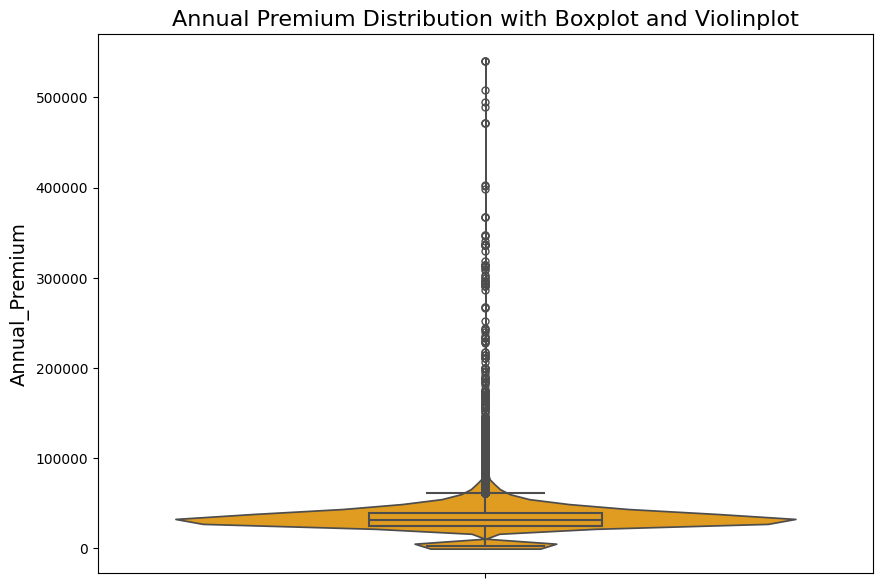

In [ ]:
plt.figure(figsize=(10, 7))
sns.violinplot(y='Annual_Premium', data=X_train, color="orange", inner=None)
sns.boxplot(y='Annual_Premium', data=X_train, color="orange", fliersize=5, linewidth=1.5, width=0.3)
plt.title('Annual Premium Distribution with Boxplot and Violinplot', fontsize=16)
plt.ylabel('Annual_Premium', fontsize=14)
plt.show()


The Annual Premium variables show a very concentrated distribution, but with some outliers. Are these outliers more correlated to Response 1 with respect to the general correlation?

In [ ]:
high_premium_total = data_train[data_train['High_Premium'] == True].shape[0]
high_premium_response_1 = data_train[(data_train['High_Premium'] == True) & (data_train['Response'] == 1)].shape[0]
high_premium_percentage = (high_premium_response_1 / high_premium_total) * 100

total_clients = data_train.shape[0]
total_response_1 = data_train[data_train['Response'] == 1].shape[0]
total_percentage = (total_response_1 / total_clients) * 100

print(f"Percentage of Response = 1 among customers with Annual Premium > 200,000: {high_premium_percentage:.2f}%")
print(f"Percentage of Response = 1 among all customers: {total_percentage:.2f}%")

Percentuale di Response = 1 tra clienti con Annual Premium > 200,000: 18.67%
Percentuale di Response = 1 tra tutti i clienti: 12.21%


It seems Annual Preium outliers correspond to a slight higher percentage of Response 1. We will keep them, standardizing the variable

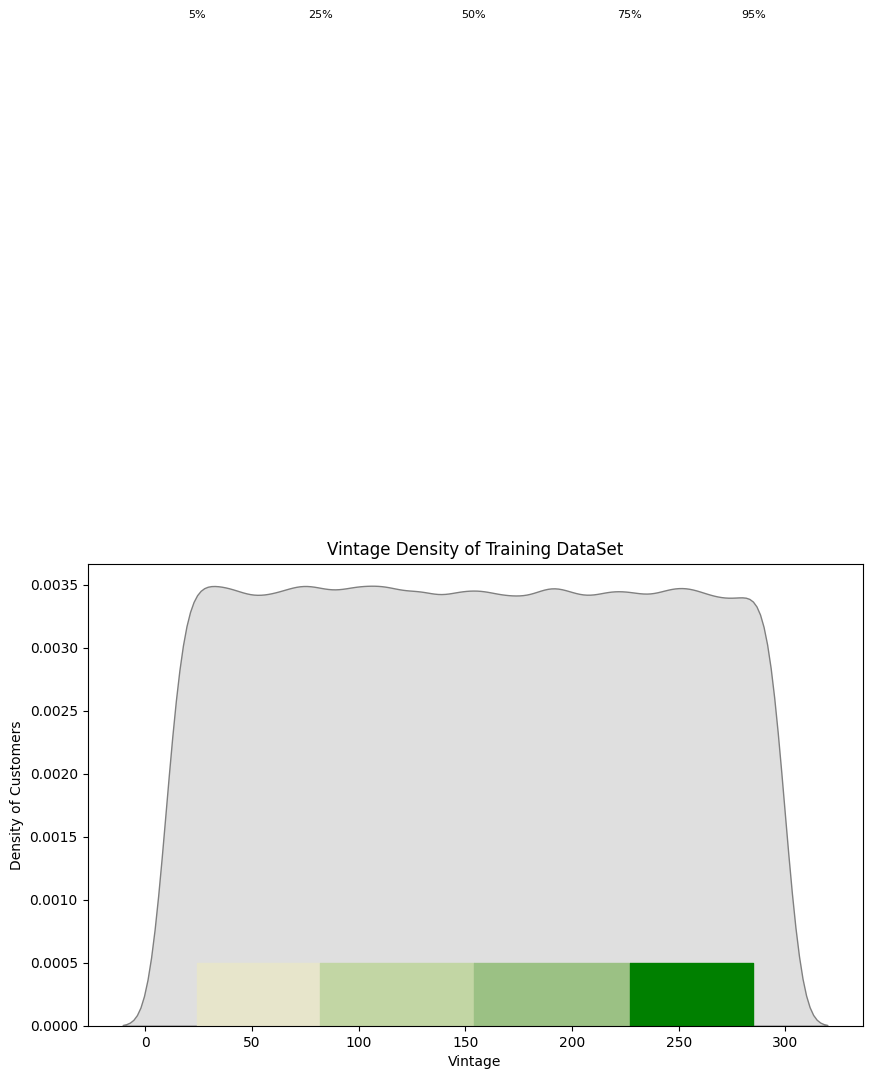

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(X_train['Vintage'], color='grey', ax=ax, fill=True)

quantiles_to_compute = [5, 25, 50, 75, 95]
quantiles = np.percentile(X_train['Vintage'], quantiles_to_compute)

colors = ['#E7E5CB', '#C2D6A4', '#9BC184', 'green']
for i in range(len(quantiles) - 1):
    ax.fill_between([quantiles[i], quantiles[i+1]], 0, 0.0005, color=colors[i])

for i, quantile in enumerate(quantiles):
    ax.text(quantile, 0.008, f'{quantiles_to_compute[i]}%', horizontalalignment='center', fontsize=8)

plt.title("Vintage Density of Training DataSet")
plt.ylabel("Density of Customers")
plt.show()

Vintage variable appears to have a symmetric and large distribution

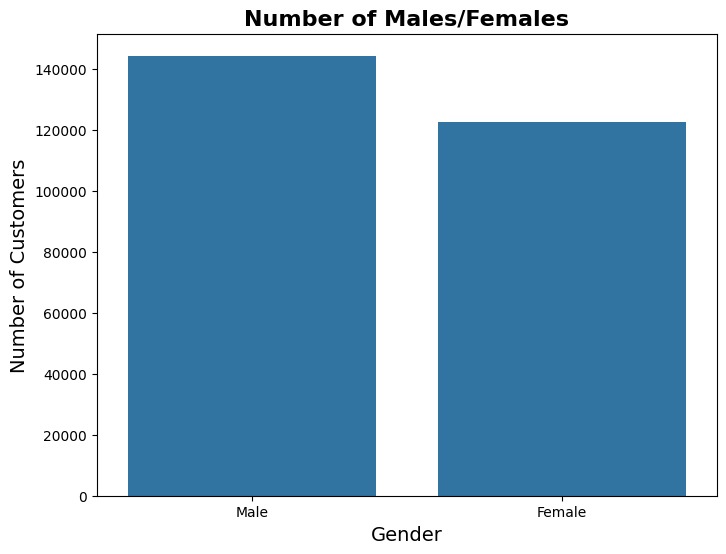

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Gender', data=data_train)

ax.set_title('Number of Males/Females', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('Gender', fontsize=14)

plt.show()

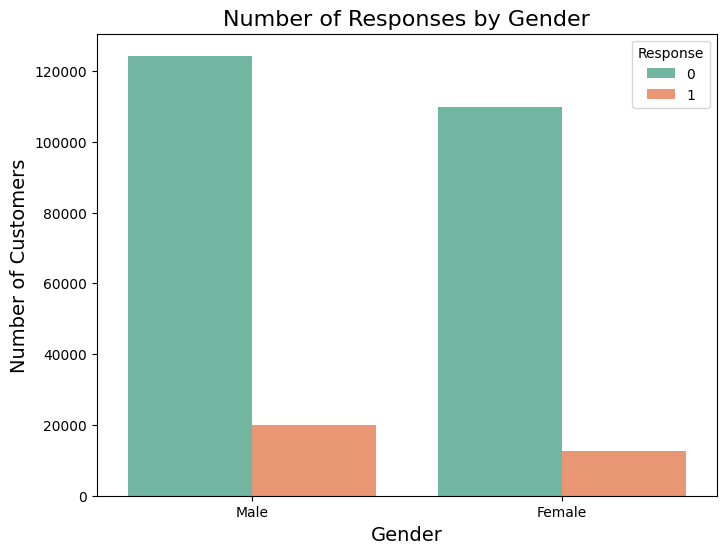

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Gender', hue='Response', data=data_train, palette='Set2')
ax.set_title('Number of Responses by Gender', fontsize=16)
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('Gender', fontsize=14)
plt.show()

There is a slight larger number of male customers compared to female customers, but Response does not seem to be more sensitive to a specific gender.
Let's check if Age appears to be somehow correlated to Annual Premium (the higher the age the larger the annual premium or the vintage variable?)

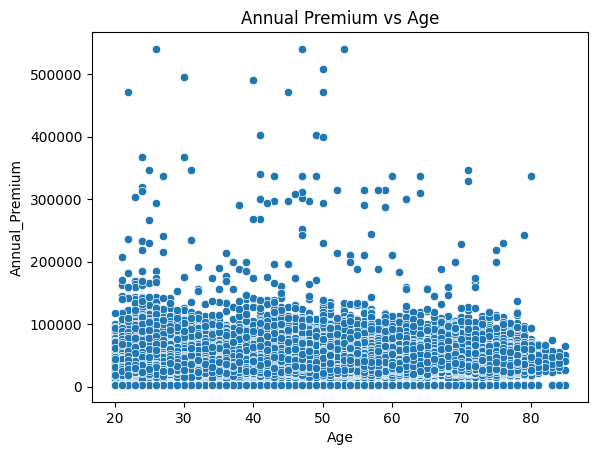

In [ ]:
sns.scatterplot(x=X_train['Age'], y=X_train['Annual_Premium'])
plt.title("Annual Premium vs Age")
plt.show()

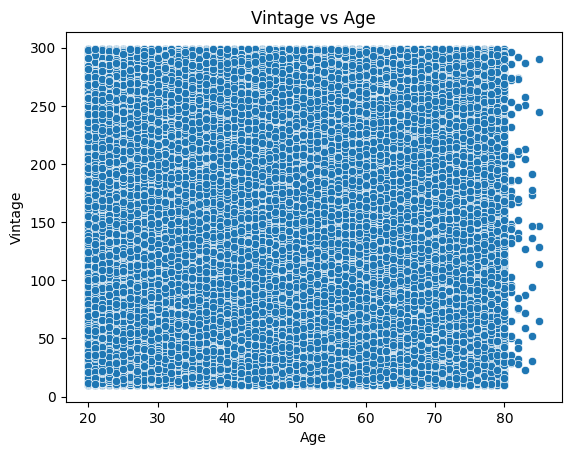

In [ ]:
sns.scatterplot(x=X_train['Age'], y=X_train['Vintage'])
plt.title("Vintage vs Age")
plt.show()

I do not see particular patterns.
I would expect a sort of correlation between Previously Insured and Response. Let's check

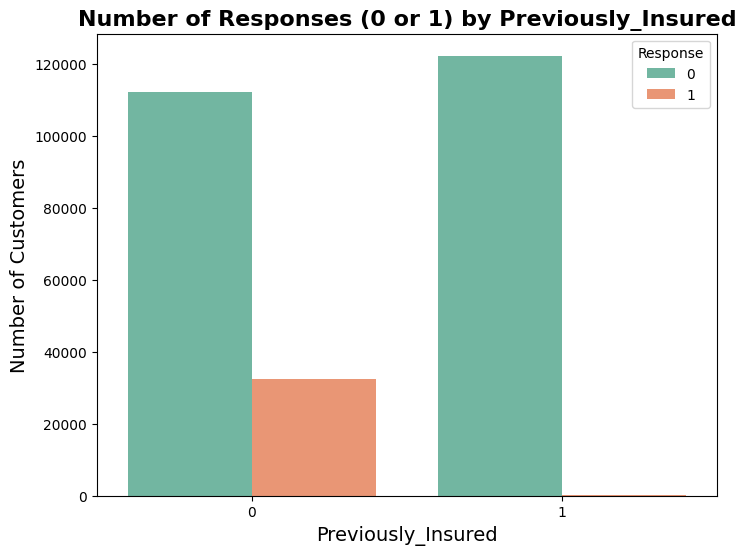

Response                 0      1     All
Previously_Insured                       
0                   112041  32469  144510
1                   122163    103  122266
All                 234204  32572  266776


In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Previously_Insured', hue='Response', data=data_train, palette='Set2')

ax.set_title('Number of Responses (0 or 1) by Previously_Insured', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('Previously_Insured', fontsize=14)

plt.show()

insurance_response_count = pd.crosstab(data_train['Previously_Insured'], data_train['Response'], margins=True)
print(insurance_response_count)


customers who were not previously insured are more likely to respond positively compared to those who were previously insured.

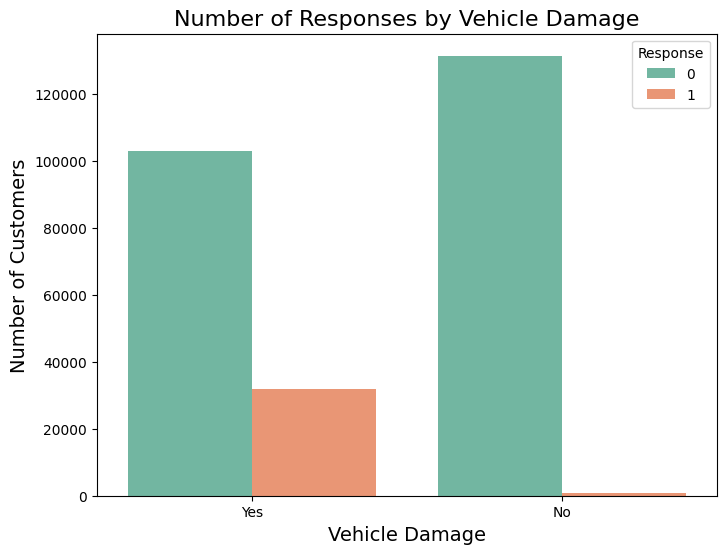

Response             0      1     All
Vehicle_Damage                       
No              131274    700  131974
Yes             102930  31872  134802
All             234204  32572  266776


In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Vehicle_Damage', hue='Response', data=data_train, palette='Set2')
ax.set_title('Number of Responses by Vehicle Damage', fontsize=16)
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('Vehicle Damage', fontsize=14)
plt.show()

damage_response_count = pd.crosstab(data_train['Vehicle_Damage'], data_train['Response'], margins=True)
print(damage_response_count)

customers with a history of vehicle damage are significantly more likely to give a positive response compared to those without prior damage

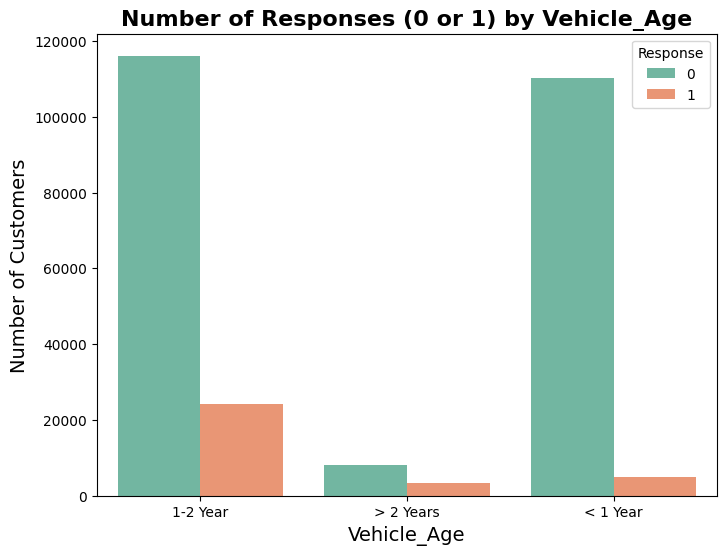

Response          0      1     All
Vehicle_Age                       
1-2 Year     116088  24272  140360
< 1 Year     110114   5006  115120
> 2 Years      8002   3294   11296
All          234204  32572  266776


In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Vehicle_Age', hue='Response', data=data_train, palette='Set2')

ax.set_title('Number of Responses (0 or 1) by Vehicle_Age', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('Vehicle_Age', fontsize=14)

plt.show()

vec_age_response_count = pd.crosstab(data_train['Vehicle_Age'], data_train['Response'], margins=True)
print(vec_age_response_count)

Even though the raw number of positive responses is higher for the 1-2 years group, the percentage comparison shows that older vehicles (those over 2 years) have a much higher probability of a positive response, followed by vehicles between 1-2 years

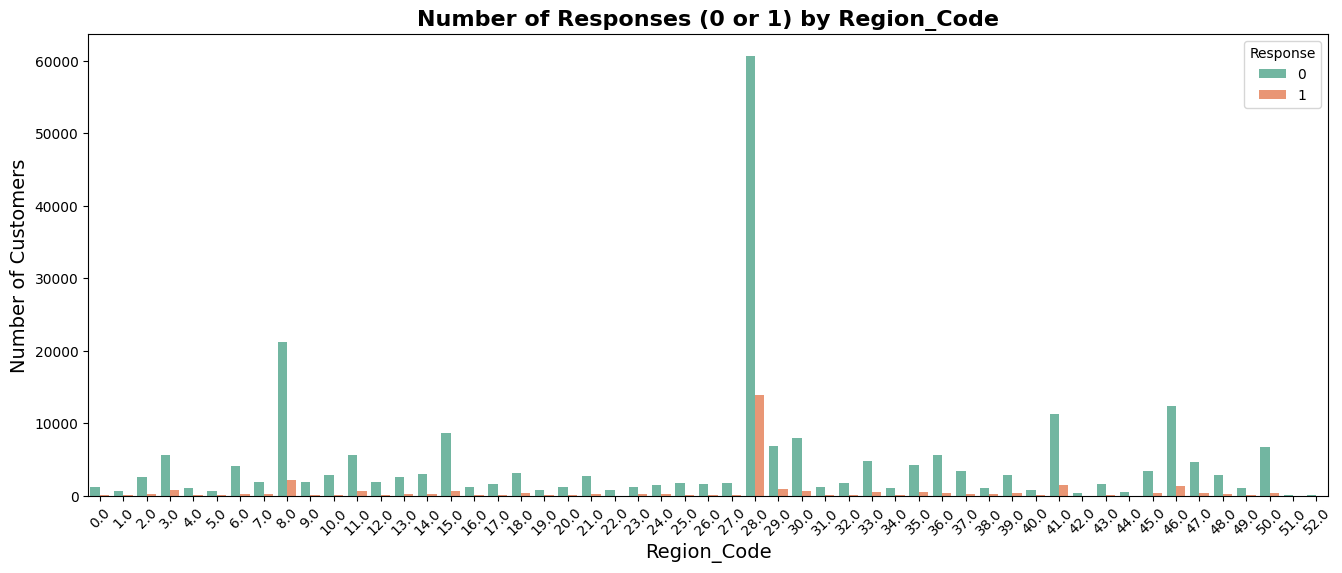

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x='Region_Code', hue='Response', data=data_train, palette='Set2')

ax.set_title('Number of Responses (0 or 1) by Region_Code', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('Region_Code', fontsize=14)
plt.xticks(rotation=45)

plt.show()

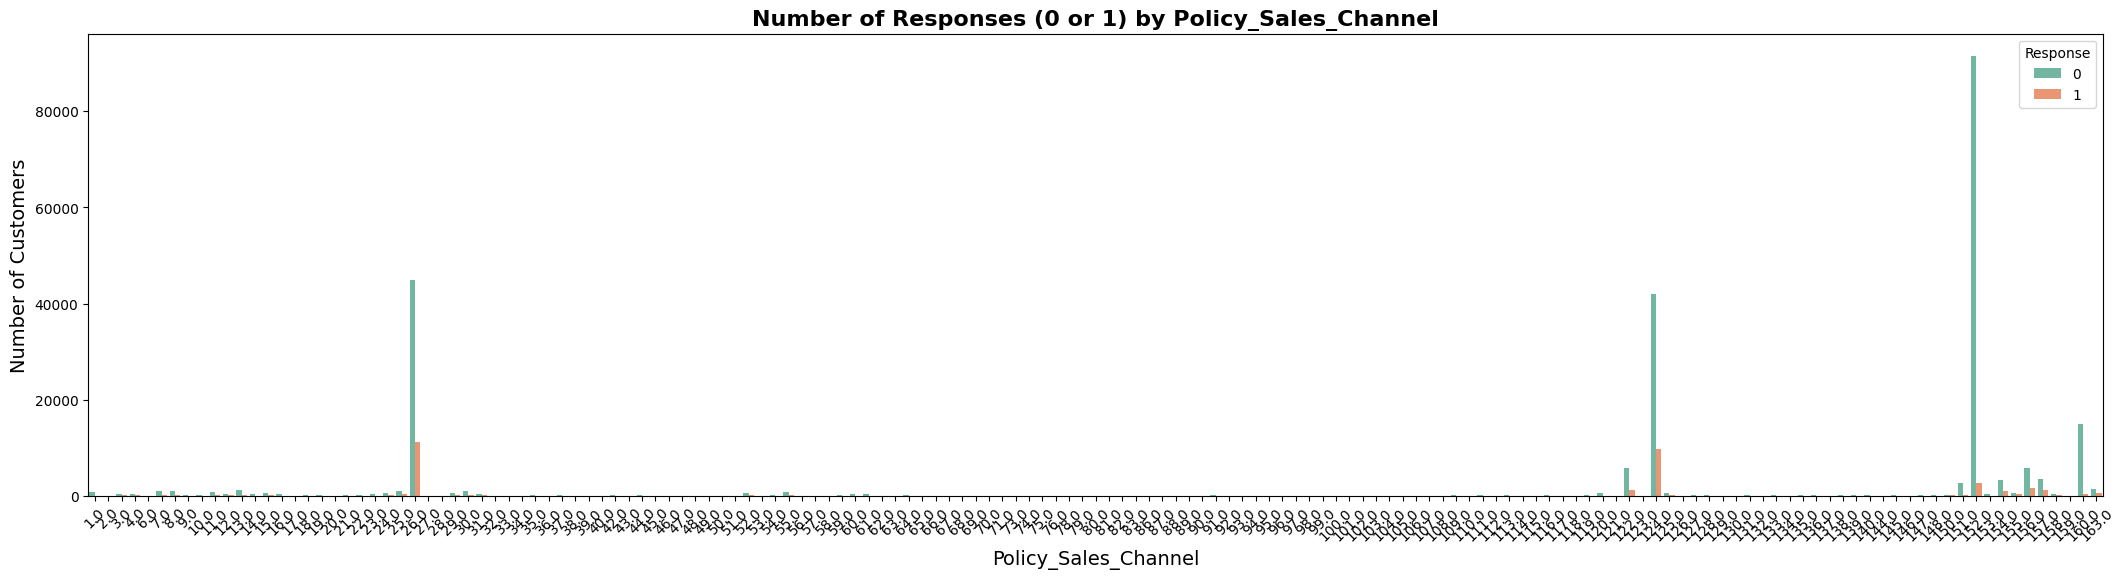

In [ ]:
plt.figure(figsize=(26, 6))
ax = sns.countplot(x='Policy_Sales_Channel', hue='Response', data=data_train, palette='Set2')

ax.set_title('Number of Responses (0 or 1) by Policy_Sales_Channel', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('Policy_Sales_Channel', fontsize=14)
plt.xticks(rotation=45)

plt.show()

Region_Code and Policy_Sales_Channel show very few category quantitatively relevant for the training. We will check if grouping the rare categories before one hot encoding will significantly impact the model prediction. If not it might be useful to keep these not relevant categories in the rare group

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.base import clone

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    """
    A custom preprocessor that transforms the 'Region_Code' and 'Policy_Sales_Channel' columns in a DataFrame
    by replacing rare categories with 'Other'.

    The class is designed to handle categorical columns and replace values that appear less frequently than
    a specified threshold with a new category called 'Other'. This is useful for reducing the impact of rare categories
    in machine learning models.

    Attributes:
    -----------
    min_freq_region : float
        The minimum frequency threshold for the 'Region_Code' column. Categories with a frequency lower than this
        value will be replaced with 'Other'.

    min_freq_policy : float
        The minimum frequency threshold for the 'Policy_Sales_Channel' column. Categories with a frequency lower than this
        value will be replaced with 'Other'.

    region_freq_ : pandas.Series
        The frequency of each category in the 'Region_Code' column, computed during the fitting process.

    policy_freq_ : pandas.Series
        The frequency of each category in the 'Policy_Sales_Channel' column, computed during the fitting process.
    """

    def __init__(self, min_freq_region=0.05, min_freq_policy=0.05):
        """
        Initializes the CustomPreprocessor with the given frequency thresholds for region and policy columns.

        Parameters:
        -----------
        min_freq_region : float, optional (default=0.05)
            The minimum frequency threshold for the 'Region_Code' column. Any category with a frequency
            lower than this value will be replaced with 'Other'.

        min_freq_policy : float, optional (default=0.05)
            The minimum frequency threshold for the 'Policy_Sales_Channel' column. Any category with a frequency
            lower than this value will be replaced with 'Other'.
        """
        self.min_freq_region = min_freq_region
        self.min_freq_policy = min_freq_policy

    def fit(self, X, y=None):
        """
        Fits the CustomPreprocessor on the input data, calculating the frequency distribution of categories
        in the 'Region_Code' and 'Policy_Sales_Channel' columns.

        Parameters:
        -----------
        X : pandas.DataFrame
            The input DataFrame with at least the 'Region_Code' and 'Policy_Sales_Channel' columns.

        y : pandas.Series or None, optional (default=None)
            The target variable, not used in this method.

        Returns:
        --------
        self : object
            Returns the instance of the CustomPreprocessor.
        """
        self.region_freq_ = X['Region_Code'].value_counts(normalize=True)
        self.policy_freq_ = X['Policy_Sales_Channel'].value_counts(normalize=True)
        return self

    def transform(self, X):
        """
        Transforms the input data by replacing rare categories in the 'Region_Code' and 'Policy_Sales_Channel'
        columns with 'Other', based on the thresholds set during initialization.

        Parameters:
        -----------
        X : pandas.DataFrame
            The input DataFrame with at least the 'Region_Code' and 'Policy_Sales_Channel' columns.

        Returns:
        --------
        X_transformed : pandas.DataFrame
            A new DataFrame with the rare categories replaced by 'Other'.
        """
        X_transformed = X.copy()

        rare_regions = self.region_freq_[self.region_freq_ < self.min_freq_region].index
        rare_policies = self.policy_freq_[self.policy_freq_ < self.min_freq_policy].index

        X_transformed['Region_Code'] = X_transformed['Region_Code'].replace(rare_regions, 'Other')
        X_transformed['Policy_Sales_Channel'] = X_transformed['Policy_Sales_Channel'].replace(rare_policies, 'Other')

        X_transformed['Region_Code'] = X_transformed['Region_Code'].astype(str)
        X_transformed['Policy_Sales_Channel'] = X_transformed['Policy_Sales_Channel'].astype(str)

        return X_transformed


class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    """
    A custom transformer for encoding categorical columns using Label Encoding. This transformer
    maps each category in the specified columns to a unique integer, allowing categorical data
    to be used in machine learning models that require numeric input.

    Attributes:
    -----------
    columns : list of str, optional (default=None)
        The columns in the input DataFrame to be transformed. If None, no columns are specified.

    label_encoders : dict
        A dictionary that stores the LabelEncoders for each column specified in 'columns'. Each
        column will have its own LabelEncoder to maintain consistent encoding across training and
        transformation.
    """
    def __init__(self, columns=None):
        """
        Initializes the LabelEncoderTransformer with the specified columns to encode.

        Parameters:
        -----------
        columns : list of str, optional (default=None)
            The list of columns to apply Label Encoding to. If None, no columns are specified.
        """
        self.columns = columns
        self.label_encoders = {}

    def fit(self, X, y=None):
        """
        Fits the LabelEncoder for each column specified in 'columns' by learning the unique
        categories in each column and mapping them to integer labels.

        Parameters:
        -----------
        X : pandas.DataFrame
            The input DataFrame containing the columns to be encoded.

        y : pandas.Series or None, optional (default=None)
            The target variable, not used in this method.

        Returns:
        --------
        self : object
            Returns the instance of the LabelEncoderTransformer.
        """
        for col in self.columns:
            le = LabelEncoder()
            X[col] = X[col].astype(str)
            le.fit(X[col])
            self.label_encoders[col] = le
        return self

    def transform(self, X):
        """
        Transforms the specified columns in the input DataFrame by replacing the categorical values
        with their corresponding integer labels.

        Parameters:
        -----------
        X : pandas.DataFrame
            The input DataFrame containing the columns to be encoded.

        Returns:
        --------
        X_transformed : pandas.DataFrame
            A new DataFrame with the encoded columns, where each category is replaced by its
            integer label.
        """
        X_transformed = X.copy()

        for col in self.columns:
            le = self.label_encoders[col]
            X_transformed[col] = le.transform(X_transformed[col].astype(str))
        return X_transformed

def build_pipeline_with_resampling(resampling_method=None, sampling_strategy=None,
                                   categorical_encoding='onehot', scaling=True, impute_missing=True, custom_preprocessing=False, prep_intensity = 0.05, bal=False):
    """
    Builds a machine learning pipeline with optional preprocessing steps, resampling,
    and model fitting. This pipeline can be customized to include categorical encoding,
    numerical scaling, missing value imputation, and different resampling techniques.

    Parameters:
    -----------
    resampling_method : str, optional (default=None)
        The resampling technique to apply to address class imbalance. Options include:
        - 'smote': Synthetic Minority Over-sampling Technique
        - 'undersample': Random under-sampling of the majority class
        - 'oversample': Random over-sampling of the minority class

    sampling_strategy : str or float, optional (default=None)
        The strategy to use when resampling. It can be a string (e.g., 'auto', 'minority', 'majority', 'not minority', etc.) or a float (the desired ratio of the minority class).
        If None, defaults to 'auto' (which typically balances the classes).

    categorical_encoding : str, optional (default='onehot')
        The method to use for encoding categorical variables. Options:
        - 'onehot': One-hot encoding for categorical columns.
        - Other encoding methods can be added if needed.

    scaling : bool, optional (default=True)
        Whether to apply feature scaling (StandardScaler) to numerical columns.

    impute_missing : bool, optional (default=True)
        Whether to impute missing values in the dataset. (Not used in this pipeline, but could be extended.)

    custom_preprocessing : bool, optional (default=False)
        Whether to include custom preprocessing for categorical features (e.g., replacing rare categories).

    prep_intensity : float, optional (default=0.05)
        The frequency threshold for the custom preprocessing step. Categories with frequency lower than this will be replaced with 'Other'.

    bal : bool, optional (default=False)
        Whether to use class balancing during model fitting. If True, LogisticRegression will use `class_weight='balanced'`.

    Returns:
    --------
    pipeline : ImbPipeline
        The machine learning pipeline with the specified preprocessing, resampling, and model steps.
    """

    numerical_cols = ['Age', 'Annual_Premium', 'Vintage']
    categorical_cols = ['Region_Code', 'Policy_Sales_Channel', 'Gender', 'Vehicle_Age', 'Vehicle_Damage']

    transformers = []
    steps = []

    if custom_preprocessing:
        steps.append(('custom_preprocessing', CustomPreprocessor(min_freq_region=prep_intensity, min_freq_policy=prep_intensity)))

    if categorical_encoding == 'onehot':
        transformers.append(('cat_onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['Region_Code', 'Policy_Sales_Channel']))

    transformers.append(('cat_label', LabelEncoderTransformer(columns=['Gender', 'Vehicle_Age', 'Vehicle_Damage']), ['Gender', 'Vehicle_Age', 'Vehicle_Damage']))

    if scaling:
        transformers.append(('num', StandardScaler(), numerical_cols))

    column_transformer = ColumnTransformer(transformers, remainder='passthrough')

    steps.append(('column_transform', column_transformer))

    if resampling_method == "smote":
        resampler = SMOTE(sampling_strategy=sampling_strategy if sampling_strategy else 'auto', random_state=42)
    elif resampling_method == "undersample":
        resampler = RandomUnderSampler(sampling_strategy=sampling_strategy if sampling_strategy else 'auto', random_state=42)
    elif resampling_method == "oversample":
        resampler = RandomOverSampler(sampling_strategy=sampling_strategy if sampling_strategy else 'auto', random_state=42)
    else:
        resampler = None

    if resampler:
        steps.append(('resample', resampler))

    if bal:
      steps.append(('model', LogisticRegression(class_weight='balanced')))
    else:
      steps.append(('model', LogisticRegression()))

    return ImbPipeline(steps=steps)


def evaluate_model(X_train, y_train, X_test, y_test,  bal,
                   threshold=0.5, resampling_method=None, sampling_strategy=None, n_splits=5, use_cv=False,
                   custom_preprocessing=False, prep_intensity=0.05,
                   categorical_encoding='onehot', scaling=True, impute_missing=True):
    """
    Evaluates a machine learning model using either cross-validation or a single training and test split.
    It builds a pipeline with preprocessing, resampling, and model fitting, then evaluates it using metrics such as
    ROC AUC, classification reports, and confusion matrices.

    Parameters:
    -----------
    X_train : pandas.DataFrame
        Training feature set (independent variables).

    y_train : pandas.Series or numpy.array
        Training target variable (dependent variable).

    X_test : pandas.DataFrame
        Test feature set (independent variables).

    y_test : pandas.Series or numpy.array
        Test target variable (dependent variable).

    bal : bool, optional (default=False)
        Whether to balance the class distribution in the logistic regression model by using class weights.
        If True, uses `class_weight='balanced'` in Logistic Regression.

    threshold : float, optional (default=0.5)
        The threshold used for classification (for converting predicted probabilities to binary labels).

    resampling_method : str, optional (default=None)
        Resampling technique to apply to the training set to address class imbalance. Options:
        - 'smote': Synthetic Minority Over-sampling Technique
        - 'undersample': Random under-sampling of the majority class
        - 'oversample': Random over-sampling of the minority class

    sampling_strategy : str or float, optional (default=None)
        Resampling strategy to apply when resampling. It can be a string ('auto', 'minority', 'majority', etc.) or a float
        representing the desired ratio of the minority class. If None, defaults to 'auto' (balancing the classes).

    n_splits : int, optional (default=5)
        The number of splits to use for cross-validation. Used when `use_cv=True`.

    use_cv : bool, optional (default=False)
        Whether to use cross-validation to evaluate the model. If False, the model is trained and evaluated using a simple train-test split.

    custom_preprocessing : bool, optional (default=False)
        Whether to apply custom preprocessing steps for handling rare categories in categorical columns.

    prep_intensity : float, optional (default=0.05)
        The frequency threshold used in custom preprocessing for categorical columns. Categories with frequency less than this will be replaced with 'Other'.

    categorical_encoding : str, optional (default='onehot')
        The method used to encode categorical variables. Options include 'onehot' (OneHotEncoder).

    scaling : bool, optional (default=True)
        Whether to apply scaling (StandardScaler) to the numerical columns.

    impute_missing : bool, optional (default=True)
        Whether to handle missing data (not directly used here but could be extended).

    Returns:
    --------
    y_pred : numpy.array
        Predicted labels for the test set after applying the threshold.

    y_pred_prob : numpy.array
        Predicted probabilities for the test set.

    y_train_pred : numpy.array
        Predicted labels for the training set after applying the threshold.

    y_train_pred_prob : numpy.array
        Predicted probabilities for the training set.

    auc_test : float
        ROC AUC score for the test set.

    auc_train : float
        ROC AUC score for the training set.
    """


    pipeline_with_resampling = build_pipeline_with_resampling(resampling_method=resampling_method,
                                                             sampling_strategy=sampling_strategy,
                                                             categorical_encoding=categorical_encoding,
                                                             scaling=scaling,
                                                             impute_missing=impute_missing,
                                                             custom_preprocessing=custom_preprocessing,
                                                             prep_intensity=prep_intensity, bal=bal)
    if use_cv:
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        best_auc = -float('inf')
        best_model = None

        for train_idx, val_idx in cv.split(X_train, y_train):
            X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
            X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]

            model_copy = clone(pipeline_with_resampling)
            model_copy.fit(X_train_fold, y_train_fold)

            y_val_prob = model_copy.predict_proba(X_val_fold)[:, 1]
            auc = roc_auc_score(y_val_fold, y_val_prob)

            # Save best model
            if auc > best_auc:
                best_auc = auc
                best_model = model_copy

        print(f"Best ROC AUC from CV: {best_auc:.4f}")

        best_model.fit(X_train, y_train)

        y_train_pred_prob = best_model.predict_proba(X_train)[:, 1]
        y_train_pred = (y_train_pred_prob >= threshold).astype(int)
        auc_train = roc_auc_score(y_train, y_train_pred_prob)

        y_pred_prob = best_model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_prob >= threshold).astype(int)
        auc_test = roc_auc_score(y_test, y_pred_prob)

        print("\n[TRAIN] Classification Report:")
        print(classification_report(y_train, y_train_pred, digits=4))
        print(f"Train ROC AUC Score: {auc_train:.4f}")

        print("\n[TEST] Classification Report:")
        print(classification_report(y_test, y_pred, digits=4))
        print(f"Test ROC AUC Score: {auc_test:.4f}")

        return y_pred, y_pred_prob, y_train_pred, y_train_pred_prob, auc_test, auc_train

    else:
        pipeline_with_resampling.fit(X_train, y_train)

        y_pred_prob = pipeline_with_resampling.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_prob >= threshold).astype(int)

        # Statistiche su train set
        print("\n[TRAIN] Classification Report:")
        y_train_pred_prob = pipeline_with_resampling.predict_proba(X_train)[:, 1]
        y_train_pred = (y_train_pred_prob >= threshold).astype(int)
        print(classification_report(y_train, y_train_pred, digits=4))
        auc_train = roc_auc_score(y_train, y_train_pred_prob)
        print(f"Train ROC AUC Score: {auc_train:.4f}")

        # Statistiche su test set
        print("\n[TEST] Classification Report:")
        print(classification_report(y_test, y_pred, digits=4))
        auc_test = roc_auc_score(y_test, y_pred_prob)
        print(f"Test ROC AUC Score: {auc_test:.4f}")

        return y_pred, y_pred_prob, y_train_pred, y_train_pred_prob, auc_test, auc_train

def evaluate_models_for_different_resampling(X_train, y_train, X_test, y_test, thresholds, resampling_methods,
                                             sampling_strategies, n_splits_values, custom_preprocessing_options,
                                            use_cv=False, balancing=[False]):
    """
    This function evaluates multiple machine learning models under different combinations of resampling methods,
    sampling strategies, thresholds, custom preprocessing options, and class balancing options. The models are
    evaluated using either cross-validation or a train-test split. The results (AUC scores, predicted probabilities)
    for each combination are stored and returned.

    Parameters:
    -----------
    X_train : pandas.DataFrame
        Training feature set (independent variables).

    y_train : pandas.Series or numpy.array
        Training target variable (dependent variable).

    X_test : pandas.DataFrame
        Test feature set (independent variables).

    y_test : pandas.Series or numpy.array
        Test target variable (dependent variable).

    thresholds : list of float
        List of threshold values to use for converting predicted probabilities to binary labels.

    resampling_methods : list of str
        List of resampling techniques to apply to the training data. Options include:
        - 'smote': Synthetic Minority Over-sampling Technique
        - 'undersample': Random under-sampling of the majority class
        - 'oversample': Random over-sampling of the minority class

    sampling_strategies : list of str or float
        List of resampling strategies to use, such as 'auto', 'minority', 'majority', or a float representing
        the desired ratio of the minority class in resampling.

    n_splits_values : list of int
        List of values for the number of splits to use in cross-validation. Used only if `use_cv=True`.

    custom_preprocessing_options : dict
        Dictionary containing custom preprocessing options. The key is the preprocessing method (e.g., 'rare_category_handling')
        and the value is a list of intensity values to experiment with.

    use_cv : bool, optional (default=False)
        Whether to use cross-validation (StratifiedKFold) to evaluate the models. If False, a single train-test split will be used.

    balancing : list of bool, optional (default=[False])
        Whether to apply class balancing by adjusting class weights in the logistic regression model. If True, uses
        `class_weight='balanced'` in Logistic Regression.

    Returns:
    --------
    results : dict
        Dictionary containing the evaluation results for each combination of parameters. The keys are strings
        that describe the combination of resampling, sampling strategy, threshold, etc., and the values are dictionaries
        containing the predicted probabilities and ROC AUC scores for both the training and test sets.

    The function also generates and displays combined ROC curves for all models.
    """
    results = {}

    for resample in resampling_methods:
      for sampling_strategy in sampling_strategies:
        for balance in balancing:
          for threshold in thresholds:
            for custom_preprocessing, values in custom_preprocessing_options.items():
              for intensity in values:

                X_train_copy=X_train.copy()
                y_train_copy=y_train.copy()
                X_test_copy=X_test.copy()
                y_test_copy=y_test.copy()

                n_splits_list = n_splits_values if use_cv else [None]

                for n_splits in n_splits_list:
                    result_key = f'{resample}_strategy_{sampling_strategy}_thresh_{threshold}_customprep_{custom_preprocessing}_balance_{balance}'
                    if custom_preprocessing:
                        result_key += f'_intensity_{intensity}'
                    if use_cv:
                        result_key += f'_splits_{n_splits}'
                    if balance:
                        result_key += f'_balance_{balance}'

                    print(f"\nEvaluating model with {result_key}")

                    y_test_pred, y_test_pred_prob, y_train_pred, y_train_pred_prob, auc_test, auc_train = evaluate_model(
                        X_train_copy, y_train_copy, X_test_copy, y_test_copy,
                        threshold=threshold, resampling_method=resample,
                        sampling_strategy=sampling_strategy, prep_intensity=intensity,
                        n_splits=n_splits if use_cv else 5, use_cv=use_cv, custom_preprocessing=custom_preprocessing, bal=balance)

                    results[result_key] = {
                        'train_pred_prob': y_train_pred_prob,
                        'test_pred_prob': y_test_pred_prob,
                        'auc_test': auc_test,
                        'auc_train': auc_train
                    }

    plot_combined_roc_curves(results, y_train, y_test, use_cv)

def plot_combined_roc_curves(results, y_train, y_test, use_cv):
    """
    This function plots combined ROC curves for the training and test datasets,
    comparing models evaluated under different configurations. The models are labeled
    with information such as resampling method, sampling strategy, threshold value,
    and AUC score.

    Parameters:
    -----------
    results : dict
        A dictionary containing model evaluation results. Each key is a string describing
        the model configuration, and the value is another dictionary with the following keys:
        - 'train_pred_prob': Predicted probabilities for the training set.
        - 'test_pred_prob': Predicted probabilities for the test set.
        - 'auc_train': ROC AUC score for the training set.
        - 'auc_test': ROC AUC score for the test set.

    y_train : pandas.Series or numpy.array
        The target labels for the training set.

    y_test : pandas.Series or numpy.array
        The target labels for the test set.

    use_cv : bool
        Whether cross-validation was used in the model evaluation. This affects how the
        results are labeled in the plot.
    """
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    for result_key in results:
        key_parts = result_key.split("_")
        resample = key_parts[0]
        strategy = key_parts[2]
        threshold = key_parts[4]
        custom_preprocessing = key_parts[6]
        balance = key_parts[8]
        auc_train = results[result_key]['auc_train']


        if custom_preprocessing == "True":
            intensity = key_parts[10]
            if use_cv:
                n_splits = key_parts[12]
                label = f'{resample if resample != "None" else "No-Resample"} {strategy if (resample != "None" and strategy != "None") else ""} Thresh={threshold if threshold != "None" else "Off"} CV={n_splits} RareCat={custom_preprocessing} {intensity} Bal={balance if balance=="True" else "False"} (AUC={auc_train:.4f})'
            else:
                label = f'{resample if resample != "None" else "No-Resample"} {strategy if (resample != "None" and strategy != "None") else ""} Thresh={threshold if threshold != "None" else "Off"} RareCat={custom_preprocessing} {intensity} Bal={balance if balance=="True" else "False"} (AUC={auc_train:.4f})'
        else:
            if use_cv:
                n_splits = key_parts[10]
                label = f'{resample if resample != "None" else "No-Resample"} {strategy if (resample != "None" and strategy != "None") else ""} Thresh={threshold if threshold != "None" else "Off"} CV={n_splits} RareCat={custom_preprocessing} Bal={balance if balance=="True" else "False"} (AUC={auc_train:.4f})'
            else:
                label = f'{resample if resample != "None" else "No-Resample"} {strategy if (resample != "None" and strategy != "None") else ""} Thresh={threshold if threshold != "None" else "Off"} RareCat={custom_preprocessing} Bal={balance if balance=="True" else "False"} (AUC={auc_train:.4f})'


        y_pred_train_prob = results[result_key]['train_pred_prob']
        fpr, tpr, _ = roc_curve(y_train, y_pred_train_prob)
        plt.plot(fpr, tpr, label=label)

    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC=0.5)")
    plt.title('ROC Curve - Training Dataset')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.legend(fontsize=8)

    plt.subplot(1, 2, 2)
    for result_key in results:
        key_parts = result_key.split("_")
        resample = key_parts[0]
        strategy = key_parts[2]
        threshold = key_parts[4]
        custom_preprocessing = key_parts[6]
        balance = key_parts[8]
        auc_test = results[result_key]['auc_test']

        if custom_preprocessing == "True":
            intensity = key_parts[10]
            if use_cv:
                n_splits = key_parts[12]
                label = f'{resample if resample != "None" else "No-Resample"} {strategy if (resample != "None" and strategy != "None") else ""} Thresh={threshold if threshold != "None" else "Off"} CV={n_splits} RareCat={custom_preprocessing} {intensity} Bal={balance if balance=="True" else "False"} (AUC={auc_test:.4f})'
            else:
                label = f'{resample if resample != "None" else "No-Resample"} {strategy if (resample != "None" and strategy != "None") else ""} Thresh={threshold if threshold != "None" else "Off"} RareCat={custom_preprocessing} {intensity} Bal={balance if balance=="True" else "False"} (AUC={auc_test:.4f})'
        else:
            if use_cv:
                n_splits = key_parts[10]
                label = f'{resample if resample != "None" else "No-Resample"} {strategy if (resample != "None" and strategy != "None") else ""} Thresh={threshold if threshold != "None" else "Off"} CV={n_splits} RareCat={custom_preprocessing} Bal={balance if balance=="True" else "False"} (AUC={auc_test:.4f})'
            else:
                label = f'{resample if resample != "None" else "No-Resample"} {strategy if (resample != "None" and strategy != "None") else ""} Thresh={threshold if threshold != "None" else "Off"} RareCat={custom_preprocessing} Bal={balance if balance=="True" else "False"} (AUC={auc_test:.4f})'
        y_pred_test_prob = results[result_key]['test_pred_prob']
        fpr, tpr, _ = roc_curve(y_test, y_pred_test_prob)
        plt.plot(fpr, tpr, label=label)

    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC=0.5)")
    plt.title('ROC Curve - Test Dataset')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.legend(fontsize=8)

    plt.tight_layout()
    plt.show()


The only model I will consider is the Logistic Regression Model, because Random Forest or other more robust models have not been treated in the lectures.

So given this model, to choose the options to train the model I will consider the fact that for the company it's critical to identify as many actual positives as possible and so it is willing to accept more false positives in return. So we should focus on recall, which indicates how many of the actual positive instances (Class 1) are correctly identified by the model.

Is the grouping of rare categories significant for the model predictions?


Evaluating model with None_strategy_None_thresh_0.5_customprep_False_balance_False

[TRAIN] Classification Report:
              precision    recall  f1-score   support

           0     0.8780    0.9997    0.9349    234204
           1     0.2857    0.0008    0.0016     32572

    accuracy                         0.8778    266776
   macro avg     0.5818    0.5003    0.4682    266776
weighted avg     0.8057    0.8778    0.8209    266776

Train ROC AUC Score: 0.8484

[TEST] Classification Report:
              precision    recall  f1-score   support

           0     0.8764    0.9997    0.9340    100195
           1     0.2973    0.0008    0.0016     14138

    accuracy                         0.8762    114333
   macro avg     0.5868    0.5003    0.4678    114333
weighted avg     0.8048    0.8762    0.8187    114333

Test ROC AUC Score: 0.8512

Evaluating model with None_strategy_None_thresh_0.5_customprep_True_balance_False_intensity_0.01

[TRAIN] Classification Report:
              

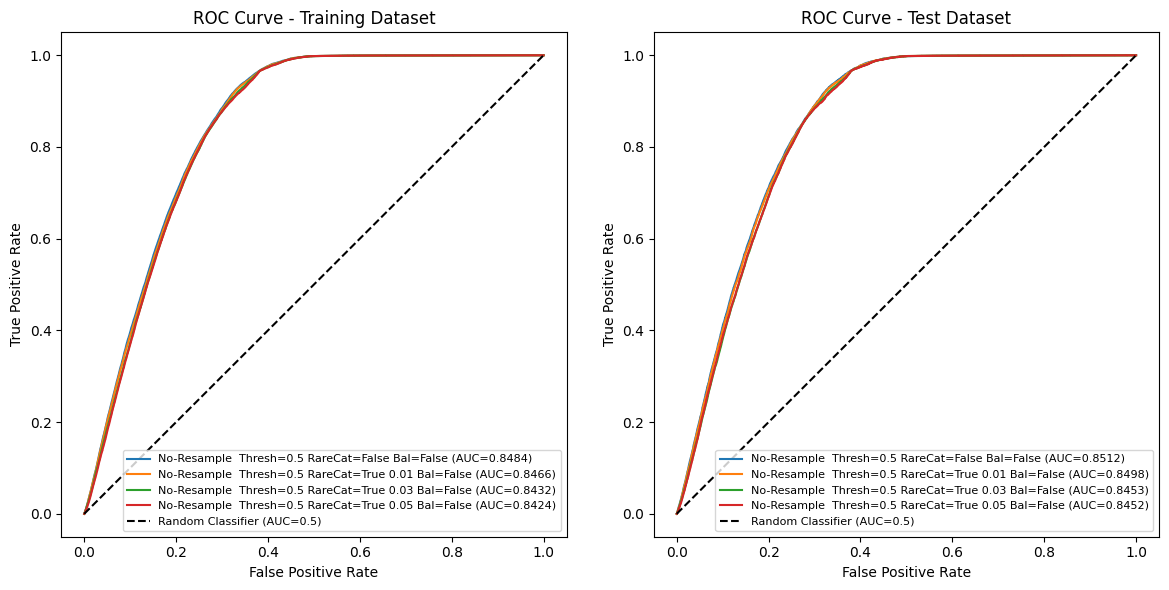

In [ ]:
thresholds = [0.5]
resampling_methods = [None]
sampling_strategies = [None]
combine_oversample_options = [None]
preprocess_intensity = [0.01, 0.03, 0.05] # different instensity of category grouping (for example 0.01 means grouping all categories corresponding to a customer frequency smaller than 1 percent)
custom_preprocessing_options = {False: [None], True: preprocess_intensity}
n_splits_values = [None]
use_cv = False

evaluate_models_for_different_resampling(X_train, y_train, X_test, y_test,
                                         thresholds, resampling_methods, sampling_strategies,
                                         n_splits_values, custom_preprocessing_options, use_cv=use_cv)


The grouping of categories does not seem to significantly impact the model prediction. So I will keep a 0.03 frequency to avoid too many encoded features

Is the class_weight parameter significantly impact for the model strategy to choose?


Evaluating model with None_strategy_None_thresh_0.5_customprep_True_balance_False_intensity_0.03

[TRAIN] Classification Report:
              precision    recall  f1-score   support

           0     0.8779    0.9999    0.9350    234204
           1     0.3636    0.0002    0.0005     32572

    accuracy                         0.8779    266776
   macro avg     0.6208    0.5001    0.4677    266776
weighted avg     0.8151    0.8779    0.8209    266776

Train ROC AUC Score: 0.8432

[TEST] Classification Report:
              precision    recall  f1-score   support

           0     0.8763    0.9999    0.9341    100195
           1     0.1111    0.0001    0.0001     14138

    accuracy                         0.8763    114333
   macro avg     0.4937    0.5000    0.4671    114333
weighted avg     0.7817    0.8763    0.8186    114333

Test ROC AUC Score: 0.8453

Evaluating model with None_strategy_None_thresh_0.5_customprep_True_balance_True_intensity_0.03_balance_True

[TRAIN] Classificat

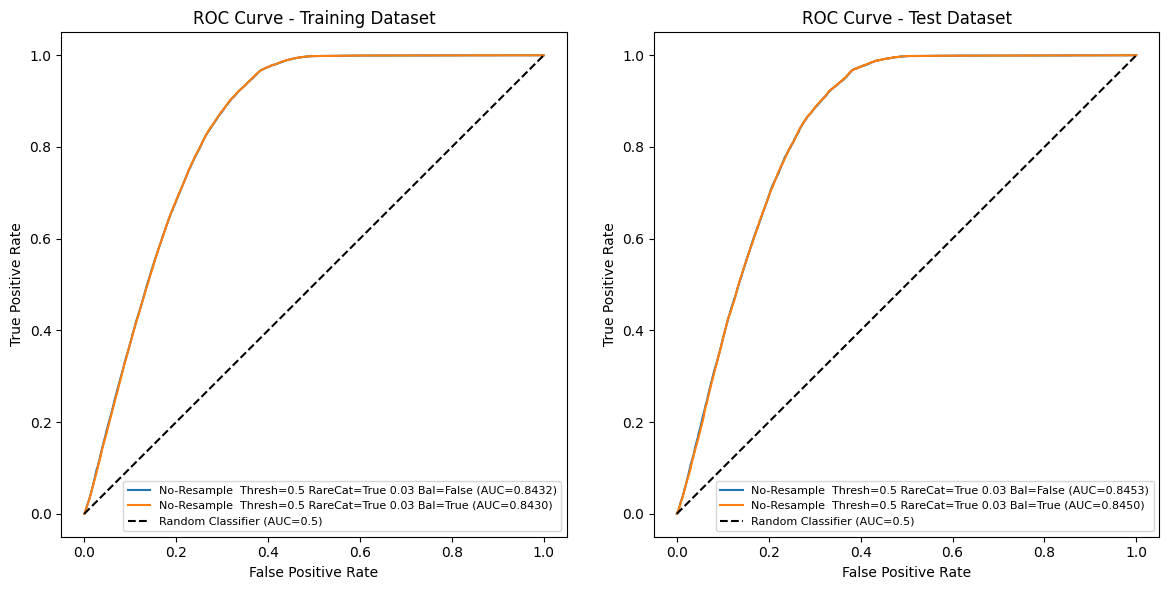

In [ ]:
thresholds = [0.5]
resampling_methods = [None]
sampling_strategies = [None]
combine_oversample_options = [None]
preprocess_intensity = [0.03]
custom_preprocessing_options = {True: preprocess_intensity}
n_splits_values = [None]
use_cv = False
balancing = [False, True]

evaluate_models_for_different_resampling(X_train, y_train, X_test, y_test,
                                         thresholds, resampling_methods, sampling_strategies,
                                         n_splits_values, custom_preprocessing_options, use_cv=use_cv, balancing=balancing)

Without balancing, the model is heavily biased towards predicting Class 0 (the majority class). As a result, recall for Class 1 is very low, and the model does not find many true positive instances, even though the accuracy is relatively high due to the dominance of Class 0.

When balancing is enabled, the model is more focused on Class 1, and as a result, the recall for Class 1 increases dramatically (to 0.9484), which means it successfully identifies almost 95% of the real positive cases. However, this comes with a trade-off: precision drops, meaning that more of the predicted positives are false positives. The accuracy also drops because the model now takes more risks in predicting positives, but it becomes better at finding the actual positives.

Given our priority to find as many real positives as possible, class_weight='balanced' appears to be the better choice.

Now we ask ourselves: is the resample of the training dataset significantly impact for the model strategy to choose? If so, which resampling method is better?



Evaluating model with None_strategy_None_thresh_0.5_customprep_True_balance_True_intensity_0.03_balance_True

[TRAIN] Classification Report:
              precision    recall  f1-score   support

           0     0.9890    0.6353    0.7737    234204
           1     0.2658    0.9493    0.4153     32572

    accuracy                         0.6737    266776
   macro avg     0.6274    0.7923    0.5945    266776
weighted avg     0.9007    0.6737    0.7299    266776

Train ROC AUC Score: 0.8430

[TEST] Classification Report:
              precision    recall  f1-score   support

           0     0.9887    0.6367    0.7746    100195
           1     0.2692    0.9484    0.4193     14138

    accuracy                         0.6752    114333
   macro avg     0.6289    0.7925    0.5970    114333
weighted avg     0.8997    0.6752    0.7307    114333

Test ROC AUC Score: 0.8450

Evaluating model with undersample_strategy_None_thresh_0.5_customprep_True_balance_True_intensity_0.03_balance_True



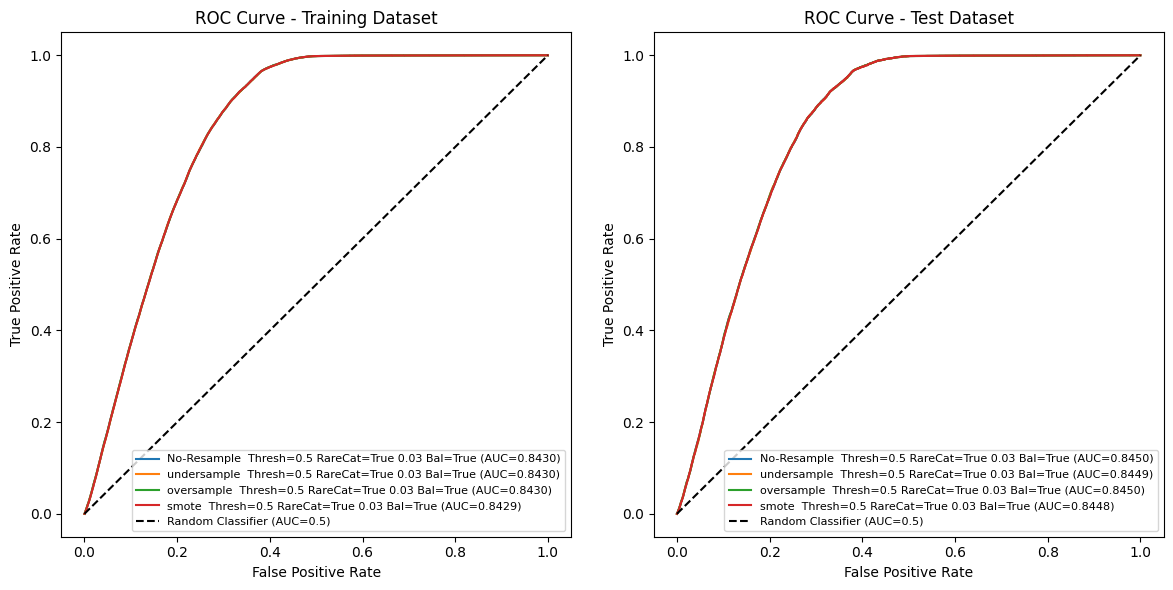

In [ ]:
thresholds = [0.5]
resampling_methods = [None, 'undersample', 'oversample', 'smote']
sampling_strategies = [None] # It means the minority class is increased to reach the size of the majority. If you want you can set also 0.3, 0.5, 0.8...
preprocess_intensity = [0.03]
custom_preprocessing_options = {True: preprocess_intensity}
n_splits_values = [None]
use_cv = False
balancing = [True]

evaluate_models_for_different_resampling(X_train, y_train, X_test, y_test,
                                         thresholds, resampling_methods, sampling_strategies,
                                         n_splits_values, custom_preprocessing_options, use_cv=use_cv, balancing=balancing)


All resampling methods (undersample, oversample, and SMOTE) perform quite similarly in terms of recall for Class 1, with only slight differences in precision. Since our priority is to maximize recall for Class 1, any of these resampling methods will likely help us achieve that goal. The impact on recall is marginally the same across all strategies, so there doesn't seem to be a strong case for choosing one over the others.
Given this, it’s reasonable to conclude that:

No resampling already gives us a very high recall for Class 1, and any of the resampling strategies don’t provide significant improvements. So we could stick with the no resampling strategy since the recall is already high, and it doesn’t come with the potential risks of overfitting or data distortion that might happen with resampling techniques like oversampling or SMOTE.

Is cross validation on training dataset impacting the model strategy to choose? We will consider to divide the training dataset in 5 or 100 splits.


Evaluating model with None_strategy_None_thresh_0.5_customprep_True_balance_False_intensity_0.03_splits_5
Best ROC AUC from CV: 0.8456

[TRAIN] Classification Report:
              precision    recall  f1-score   support

           0     0.8779    0.9999    0.9350    234204
           1     0.3636    0.0002    0.0005     32572

    accuracy                         0.8779    266776
   macro avg     0.6208    0.5001    0.4677    266776
weighted avg     0.8151    0.8779    0.8209    266776

Train ROC AUC Score: 0.8432

[TEST] Classification Report:
              precision    recall  f1-score   support

           0     0.8763    0.9999    0.9341    100195
           1     0.1111    0.0001    0.0001     14138

    accuracy                         0.8763    114333
   macro avg     0.4937    0.5000    0.4671    114333
weighted avg     0.7817    0.8763    0.8186    114333

Test ROC AUC Score: 0.8453

Evaluating model with None_strategy_None_thresh_0.5_customprep_True_balance_False_intensity

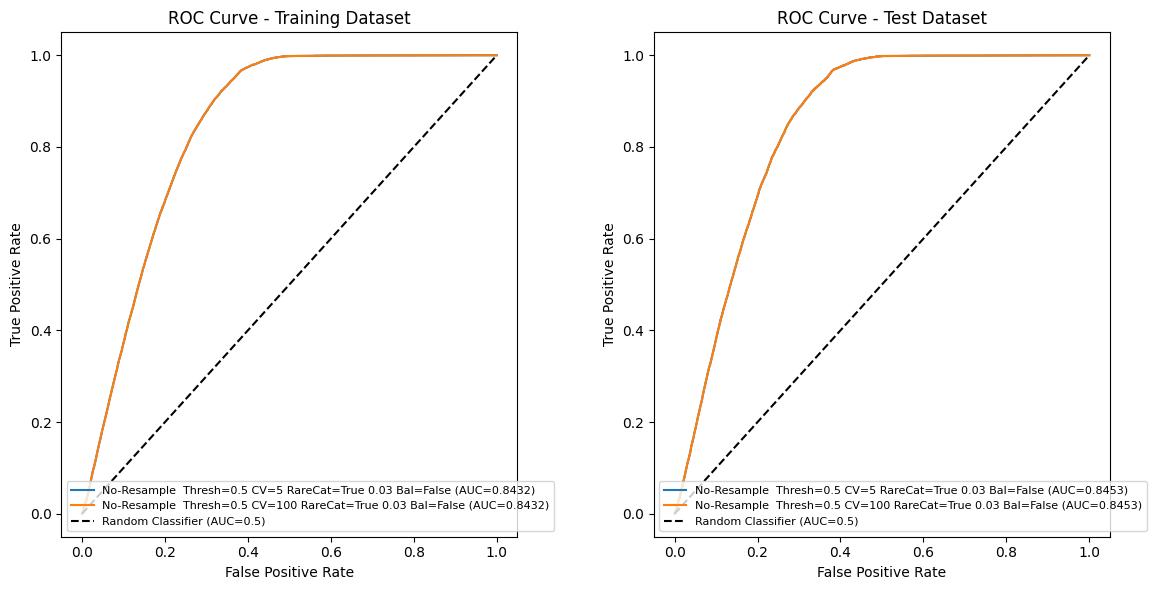

In [ ]:
thresholds = [0.5]
resampling_methods = [None]
sampling_strategies = [None]
preprocess_intensity = [0.03]
custom_preprocessing_options = {True: preprocess_intensity}
n_splits_values = [5, 100]
use_cv = True

evaluate_models_for_different_resampling(X_train, y_train, X_test, y_test,
                                         thresholds, resampling_methods, sampling_strategies,
                                         n_splits_values, custom_preprocessing_options, use_cv=use_cv)


It seems that while cross-validation with more splits (100) helps to tune the model slightly better and may improve the training phase (as seen in the higher ROC AUC during CV), it does not significantly change the model's final performance on the test set. So we will proceed without cross validation.

Is threshold value for the decision boundary impacting the model strategy to choose?


Evaluating model with None_strategy_None_thresh_0.5_customprep_True_balance_True_intensity_0.03_balance_True

[TRAIN] Classification Report:
              precision    recall  f1-score   support

           0     0.9890    0.6353    0.7737    234204
           1     0.2658    0.9493    0.4153     32572

    accuracy                         0.6737    266776
   macro avg     0.6274    0.7923    0.5945    266776
weighted avg     0.9007    0.6737    0.7299    266776

Train ROC AUC Score: 0.8430

[TEST] Classification Report:
              precision    recall  f1-score   support

           0     0.9887    0.6367    0.7746    100195
           1     0.2692    0.9484    0.4193     14138

    accuracy                         0.6752    114333
   macro avg     0.6289    0.7925    0.5970    114333
weighted avg     0.8997    0.6752    0.7307    114333

Test ROC AUC Score: 0.8450

Evaluating model with None_strategy_None_thresh_0.4_customprep_True_balance_True_intensity_0.03_balance_True

[TRAIN]

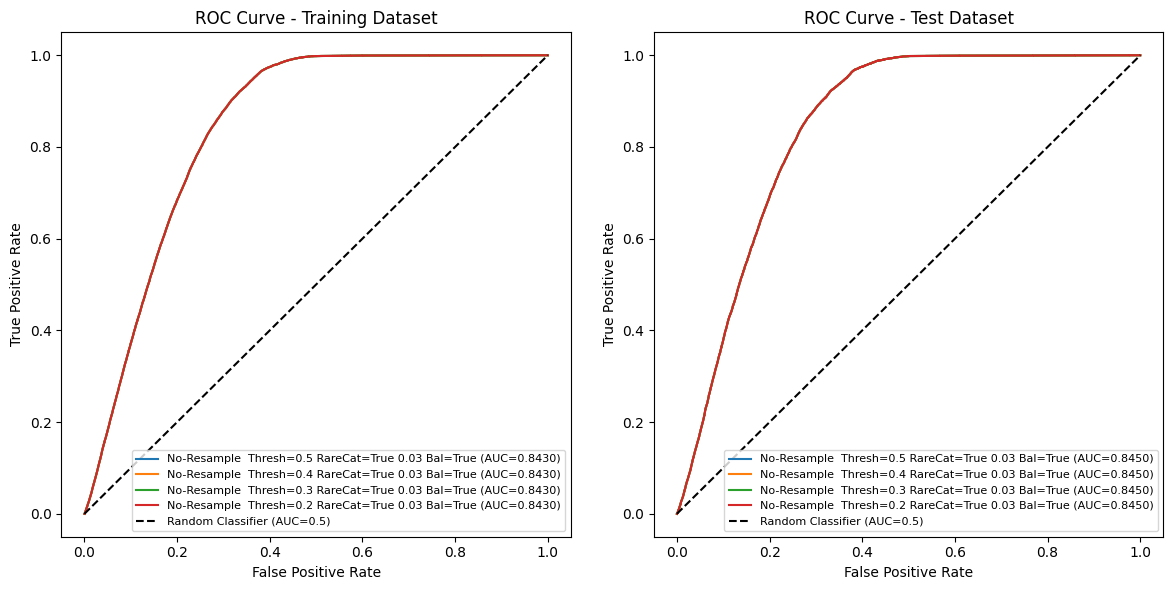

In [ ]:
thresholds = [0.5, 0.4, 0.3, 0.2]
resampling_methods = [None]
sampling_strategies = [None]
preprocess_intensity = [0.03]
custom_preprocessing_options = {True: preprocess_intensity}
n_splits_values = [None]
use_cv = False
balancing = [True]

evaluate_models_for_different_resampling(X_train, y_train, X_test, y_test,
                                         thresholds, resampling_methods, sampling_strategies,
                                         n_splits_values, custom_preprocessing_options, use_cv=use_cv, balancing=balancing)

While the threshold does impact precision, recall, and accuracy, it does not significantly affect the ROC AUC score. Since you prioritize finding as many real positives as possible (which means maximizing recall), lowering the threshold increases recall but sacrifices precision, as expected.
We will continue with the threshold of 0.2 as decision boundary

The final chosen model strategy is:

| Resampling Strategy | Decision Boundary Threshold | Custom Preprocessing | Class Weights Balanced | Precision | Recall | F1-Score | Accuracy | ROC AUC |
|---------------------|-----------------------------|----------------------|------------------------|-----------|--------|----------|----------|---------|
| No-Resample         | 0.2                         |  Yes, 0.03 frequency |           Yes          |  0.24   | 0.99 | 0.39   | 0.61   | 0.85  |